In [1]:
# Data processing script
# 
# assign working directory path
wd.path <- "~/in"
setwd(wd.path)
set.seed(1234)
library(dplyr)
# library(foreach)
# library(caret)
# library(reshape2)
library(rms)
library(WeightedROC)

#Sample mode function from Source: https://stackoverflow.com/questions/2547402/is-there-a-built-in-function-for-finding-the-mode
Mode <- function(x, na.rm = FALSE) {
  if (na.rm) {
    x = x[!is.na(x)]
  }
  
  ux <- unique(x)
  return(ux[which.max(tabulate(match(x, ux)))])
}

imputationFunction <- function(imputeToData, imputeFromData, FUN, missingCols, suffix){
  # imputeToData -  Imputation to be done on this data
  # imputeFromData - Imputations calculation from this data
  # FUN - imputation function
  # missingCols - missing value column names
  # suffix - suffix to add after column name
  
  imputeToData <- imputeToData[, names(imputeToData) %in% missingCols]
  imputeFromData <- imputeFromData[, names(imputeFromData) %in% missingCols]
  imputeVec <- apply(imputeFromData, 2, function(x) FUN(x, na.rm = T))
  
  for (i in 1:length(missingCols)) {
    imputeToxData[is.na(imputeToData[, names(imputeToData) %in% missingCols[i]])
                 , names(imputeToData) %in% missingCols[i]] <- imputeVec[names(imputeVec) %in% missingCols[i]]
  }
  
  names(imputeToData) <- paste0(names(imputeToData), suffix)
  return(imputeToData)
}


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:dplyr’:

    combine, src, summarize

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units

Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve



# Initial Data Processing: join in Weight and Fold

In [2]:
test <- read.csv('application_test.csv') # applications test data
train <- read.csv('application_train.csv') # applications train data

# storing column names for later
saveNames <- names(train)

# columns with missing values
missingCols <-  names(train)[apply(train, 2, function(x) sum(is.na(x))) > 0]

In [ ]:
weights <- read.csv('Weights_and_fold.csv')
print("Weights v1 loaded")
train <- cbind(train) %>% left_join(weights, by = "SK_ID_CURR")
write.csv(train,'application_train_v1.csv')
print("Train v1 written")

In [ ]:
weights <- read.csv('V2_weight_R_code(Alex)/Train_Weights_V2.csv')
print("Weights v2 loaded")
train <- train %>% select(-Weights) %>% left_join(weights, by = "SK_ID_CURR") %>% select(-X)
write.csv(train,'application_train_v2.csv')
print("Train v2 written")

# Prepare Data Imputation

In [2]:
train <- read.csv('application_train_v2.csv')
test <- read.csv('application_test.csv')

In [3]:
train_imp <- train %>% select(-X)
train_imp <- train_imp[,c(1,3:ncol(train_imp),2)]

test_imp = test
test_imp$fold <- rep(NA,nrow(test_imp))
test_imp$Weights <- rep(NA,nrow(test_imp))
test_imp$TARGET <- rep(NA,nrow(test_imp))

train_test <- rbind(train_imp, test_imp)

In [4]:
head(train_test)

SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,⋯,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,fold,Weights,TARGET
100002,Cash loans,M,N,Y,0,202500,406597.5,24700.5,351000,⋯,0,0,0,0,0,0,1,4,0.49764398,1
100003,Cash loans,F,N,N,0,270000,1293502.5,35698.5,1129500,⋯,0,0,0,0,0,0,0,4,0.02863412,0
100004,Revolving loans,M,Y,Y,0,67500,135000.0,6750.0,135000,⋯,0,0,0,0,0,0,0,5,0.01805381,0
100006,Cash loans,F,N,Y,0,135000,312682.5,29686.5,297000,⋯,0,NA,NA,NA,NA,NA,NA,4,0.96792536,0
100007,Cash loans,M,N,Y,0,121500,513000.0,21865.5,513000,⋯,0,0,0,0,0,0,0,5,0.23806437,0
100008,Cash loans,M,N,Y,0,99000,490495.5,27517.5,454500,⋯,0,0,0,0,0,1,1,1,0.02018754,0


In [5]:
# Mechanically create a formula for imputation
M = train_test

col_set = M %>% names()
col_set = col_set[!col_set %in% "TARGET"]

string_formula = "TARGET~"
for(i in col_set){
  if(class(M[[i]]) == "numeric"){
    tmp_component = paste0("+",i)
  }
  if(class(M[[i]]) != "numeric"){
    tmp_component = paste0("+",i)
  }
  string_formula = paste0(string_formula, tmp_component)  
}
requested_formula = as.formula(string_formula)
requested_formula

TARGET ~ +SK_ID_CURR + NAME_CONTRACT_TYPE + CODE_GENDER + FLAG_OWN_CAR + 
    FLAG_OWN_REALTY + CNT_CHILDREN + AMT_INCOME_TOTAL + AMT_CREDIT + 
    AMT_ANNUITY + AMT_GOODS_PRICE + NAME_TYPE_SUITE + NAME_INCOME_TYPE + 
    NAME_EDUCATION_TYPE + NAME_FAMILY_STATUS + NAME_HOUSING_TYPE + 
    REGION_POPULATION_RELATIVE + DAYS_BIRTH + DAYS_EMPLOYED + 
    DAYS_REGISTRATION + DAYS_ID_PUBLISH + OWN_CAR_AGE + FLAG_MOBIL + 
    FLAG_EMP_PHONE + FLAG_WORK_PHONE + FLAG_CONT_MOBILE + FLAG_PHONE + 
    FLAG_EMAIL + OCCUPATION_TYPE + CNT_FAM_MEMBERS + REGION_RATING_CLIENT + 
    REGION_RATING_CLIENT_W_CITY + WEEKDAY_APPR_PROCESS_START + 
    HOUR_APPR_PROCESS_START + REG_REGION_NOT_LIVE_REGION + REG_REGION_NOT_WORK_REGION + 
    LIVE_REGION_NOT_WORK_REGION + REG_CITY_NOT_LIVE_CITY + REG_CITY_NOT_WORK_CITY + 
    LIVE_CITY_NOT_WORK_CITY + ORGANIZATION_TYPE + EXT_SOURCE_1 + 
    EXT_SOURCE_2 + EXT_SOURCE_3 + APARTMENTS_AVG + BASEMENTAREA_AVG + 
    YEARS_BEGINEXPLUATATION_AVG + YEARS_BUILD_AVG + COMMO

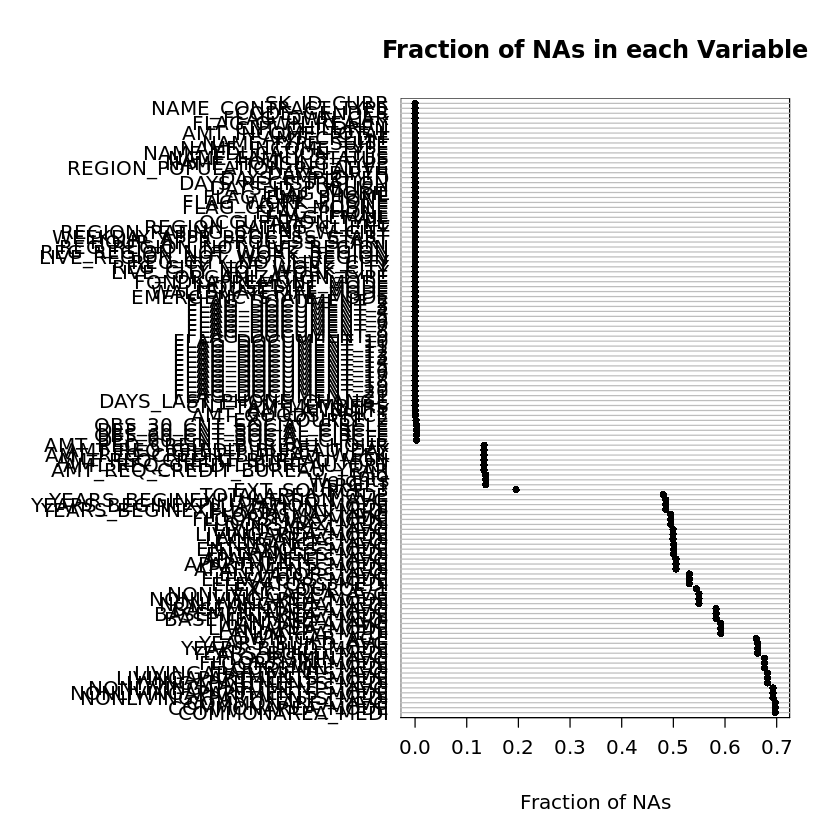

In [6]:
na.patterns <- naclus(M)
naplot(na.patterns, 'na per var')

In [7]:
# Manually convert some of the 'Unknown' levels to NA
M[M == 'XNA' | M == 'Unknown'] <- NA
M = droplevels(M)

# Code example to see the use of dropLevels, dropping factor level with no observation
# train2 <- subset(train_imp, select= c(CODE_GENDER, NAME_FAMILY_STATUS))
# str(train2)
# train2 = droplevels(train2)
# str(train2)

In [ ]:
# Trying to understand why FLAG_OWN_CAR is tagged as having too few variations
M_small <- M[, c('TARGET','NAME_CONTRACT_TYPE','CODE_GENDER',
    'FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN','AMT_INCOME_TOTAL',
    'AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE','REGION_POPULATION_RELATIVE','DAYS_BIRTH',
    'DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','OWN_CAR_AGE',
    'FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE',
    'FLAG_PHONE','FLAG_EMAIL','OCCUPATION_TYPE','CNT_FAM_MEMBERS')]
describe(M_small)

In [8]:
set.seed(17) # so can reproduce random aspects
old <- Sys.time()
mi <- aregImpute(~ TARGET + NAME_CONTRACT_TYPE + CODE_GENDER + 
    #FLAG_OWN_CAR + 
    AMT_CREDIT/AMT_GOODS_PRICE + AMT_CREDIT/AMT_ANNUITY + AMT_ANNUITY/AMT_INCOME_TOTAL +
    EXT_SOURCE_1 + EXT_SOURCE_2 + EXT_SOURCE_3 +
    FLAG_OWN_REALTY + CNT_CHILDREN + AMT_INCOME_TOTAL + 
    AMT_CREDIT + AMT_ANNUITY + AMT_GOODS_PRICE + NAME_TYPE_SUITE + 
    # NAME_INCOME_TYPE + 
    NAME_EDUCATION_TYPE + NAME_FAMILY_STATUS + 
    NAME_HOUSING_TYPE + REGION_POPULATION_RELATIVE + DAYS_BIRTH + 
    DAYS_EMPLOYED + DAYS_REGISTRATION + DAYS_ID_PUBLISH + OWN_CAR_AGE + 
    FLAG_MOBIL + FLAG_EMP_PHONE + FLAG_WORK_PHONE + FLAG_CONT_MOBILE + 
    FLAG_PHONE + FLAG_EMAIL + OCCUPATION_TYPE + CNT_FAM_MEMBERS
                 , data=M, n.impute=10, nk=4, pr=FALSE)
new <- Sys.time()
print(old)
print(new)

Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots 

 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx 

 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx 

 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx 

 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx = TRUE):
“could not obtain 4 interior knots with default algorithm.
 Used alternate algorithm to obtain 3 knots”Warning message in rcspline.eval(z, knots = parms, nk = nk, inclx 

[1] "2018-08-26 03:49:17 UTC"
[1] "2018-08-26 07:24:37 UTC"


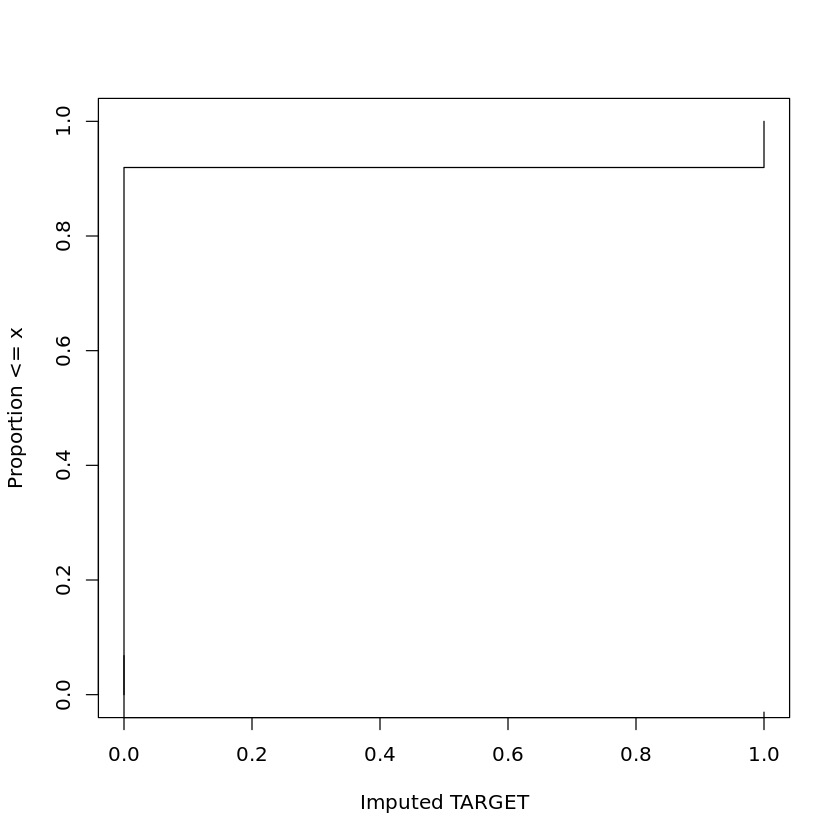

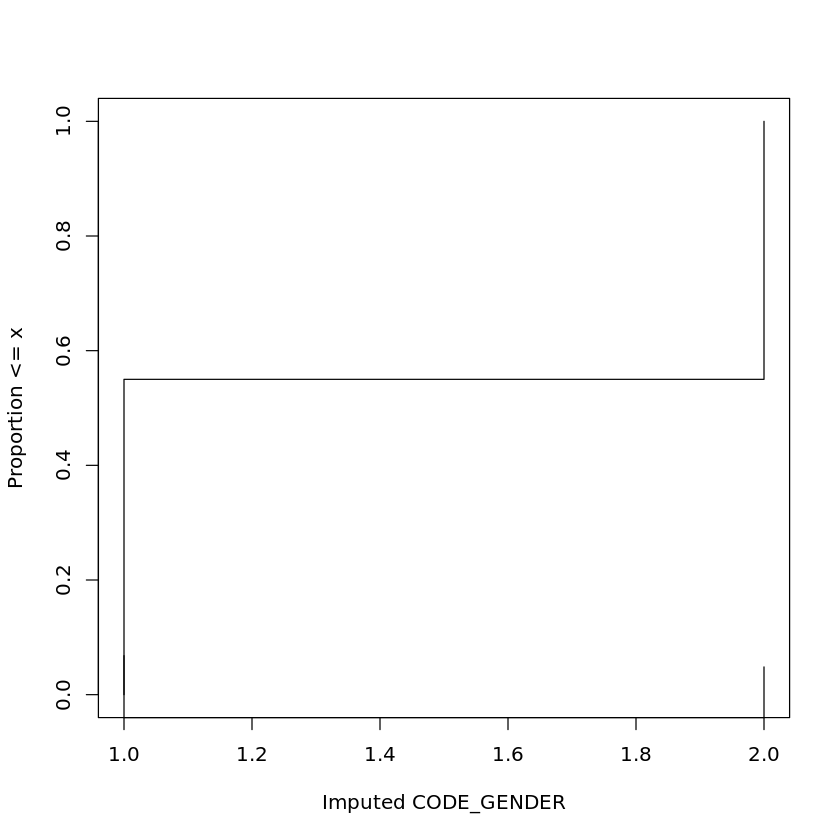

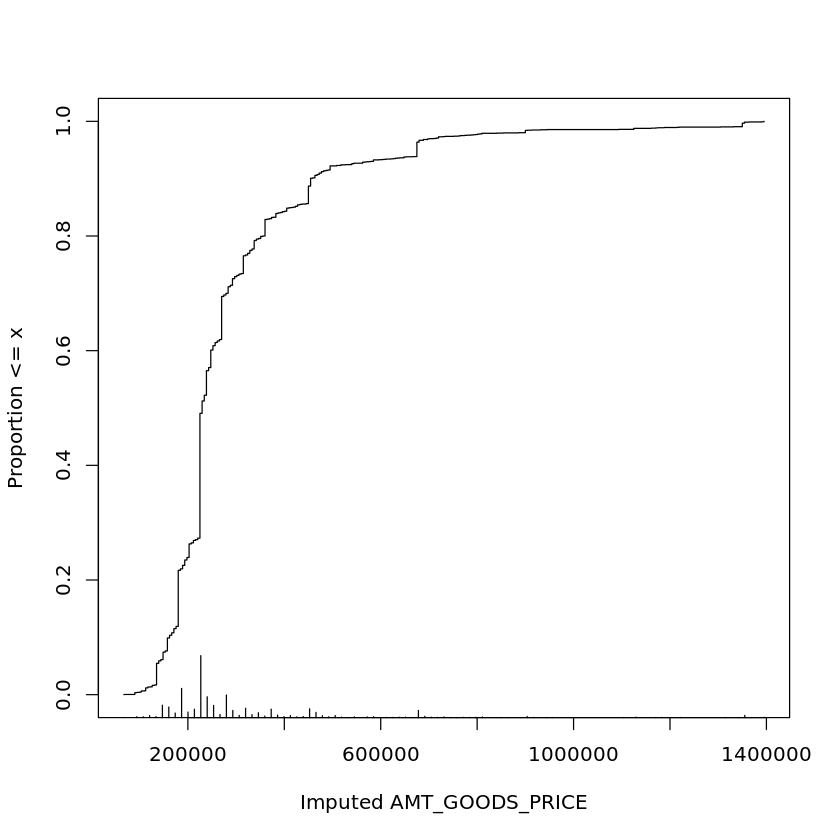

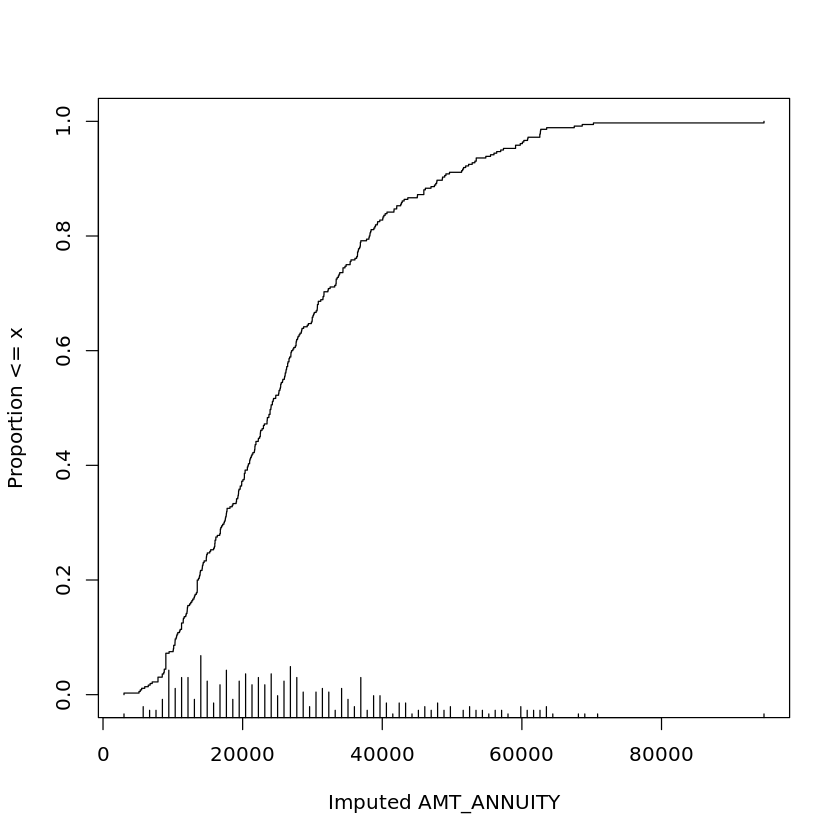

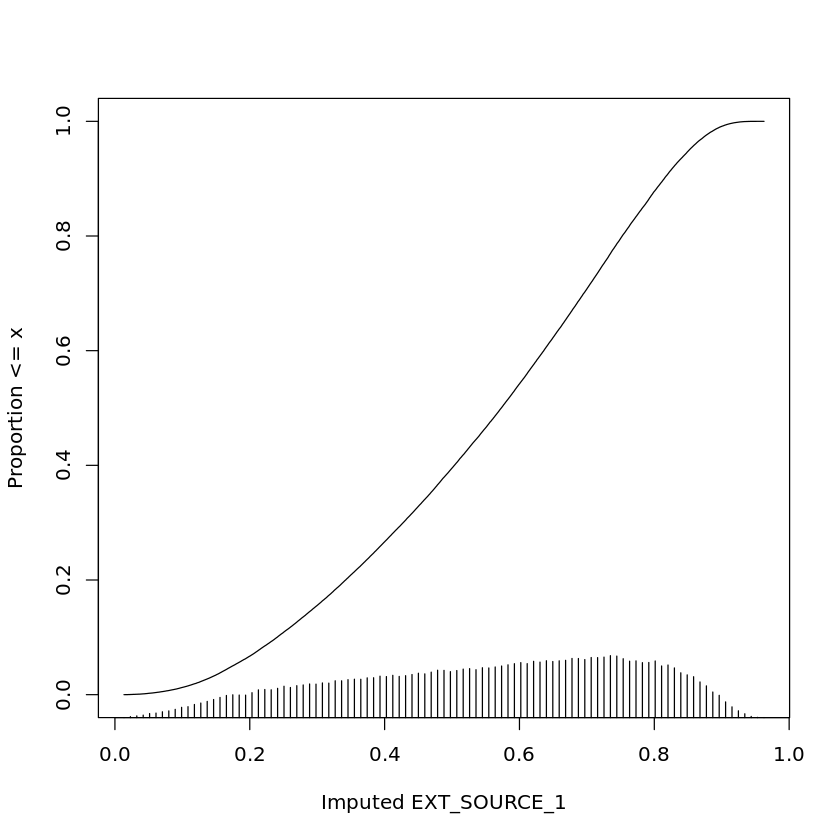

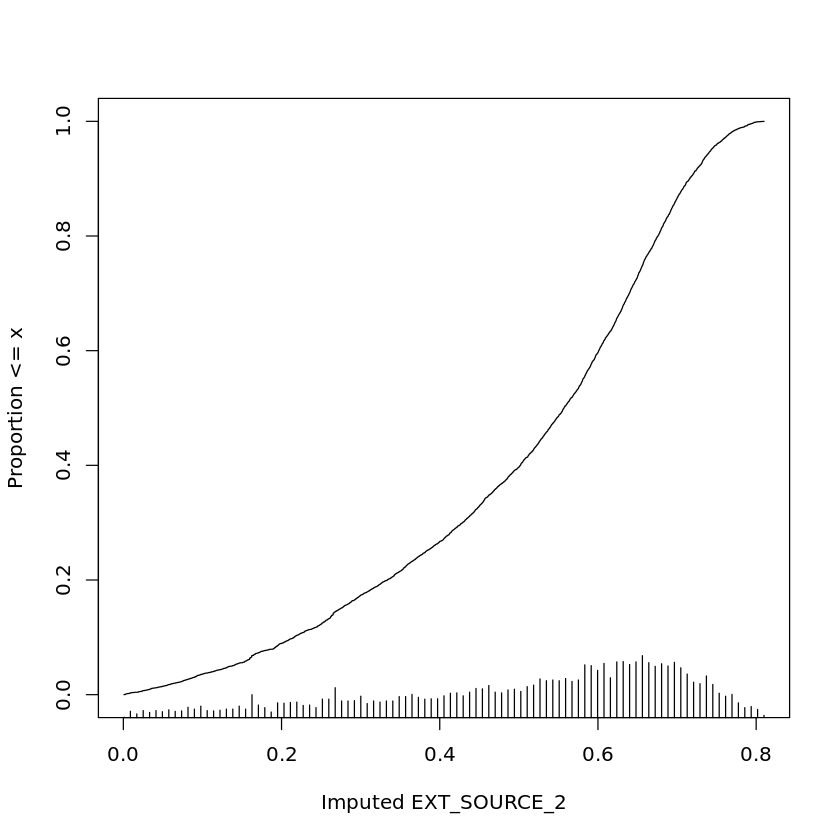

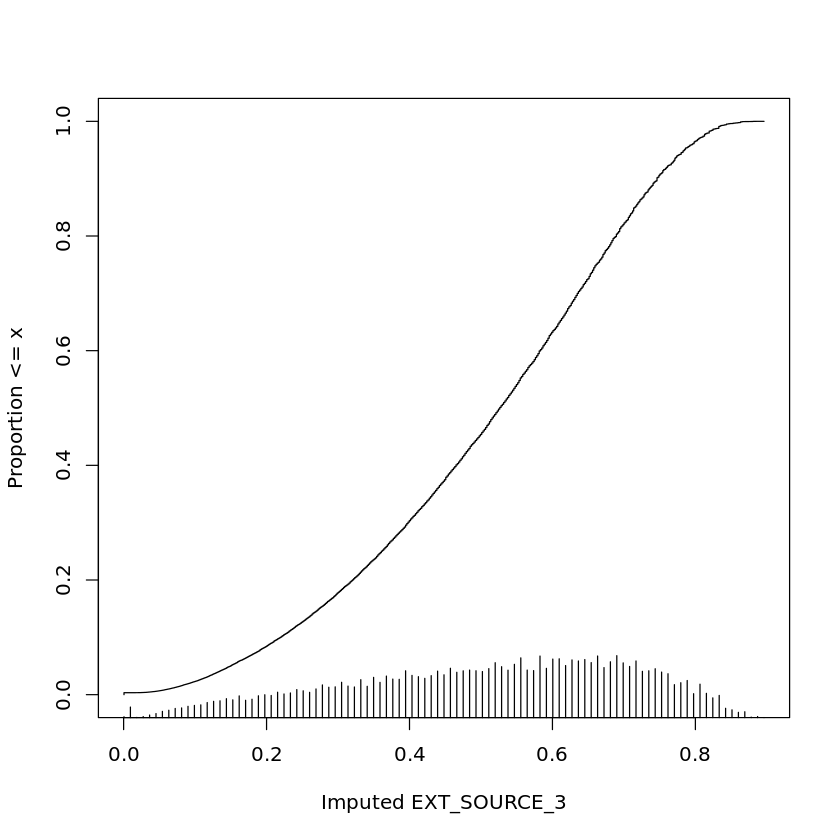

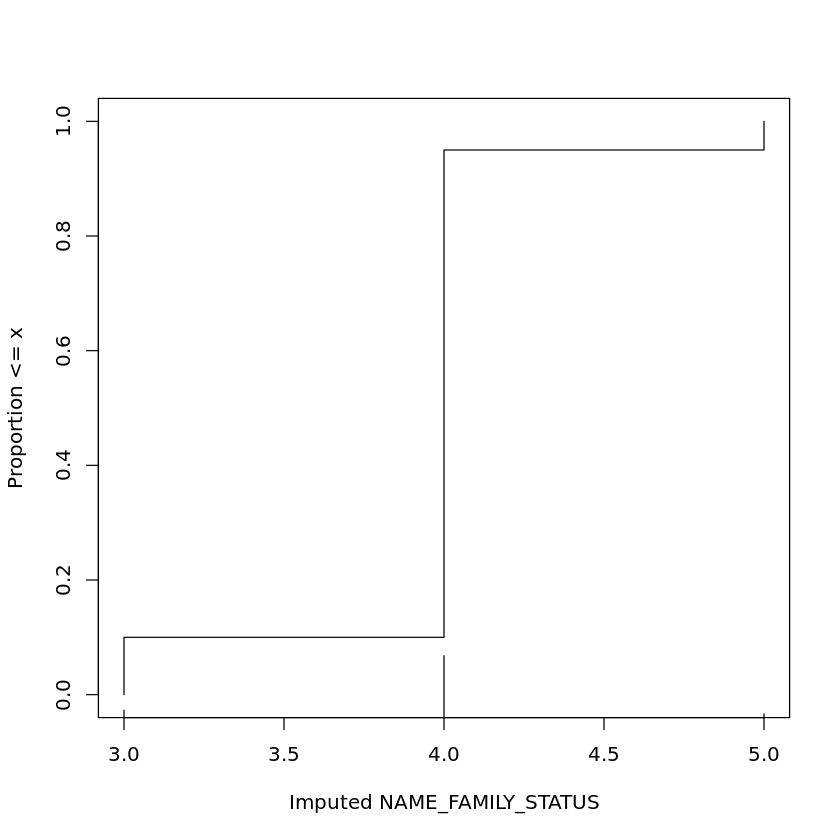

ERROR: Error in cut.default(x, c(bins[1] - delta, bins)): 'breaks' are not unique


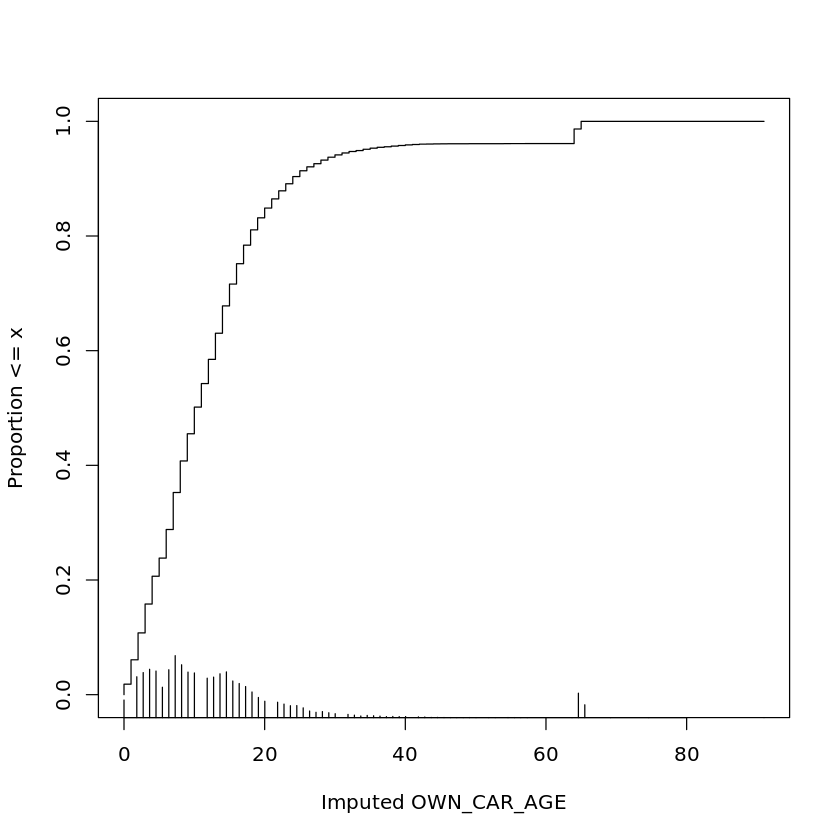

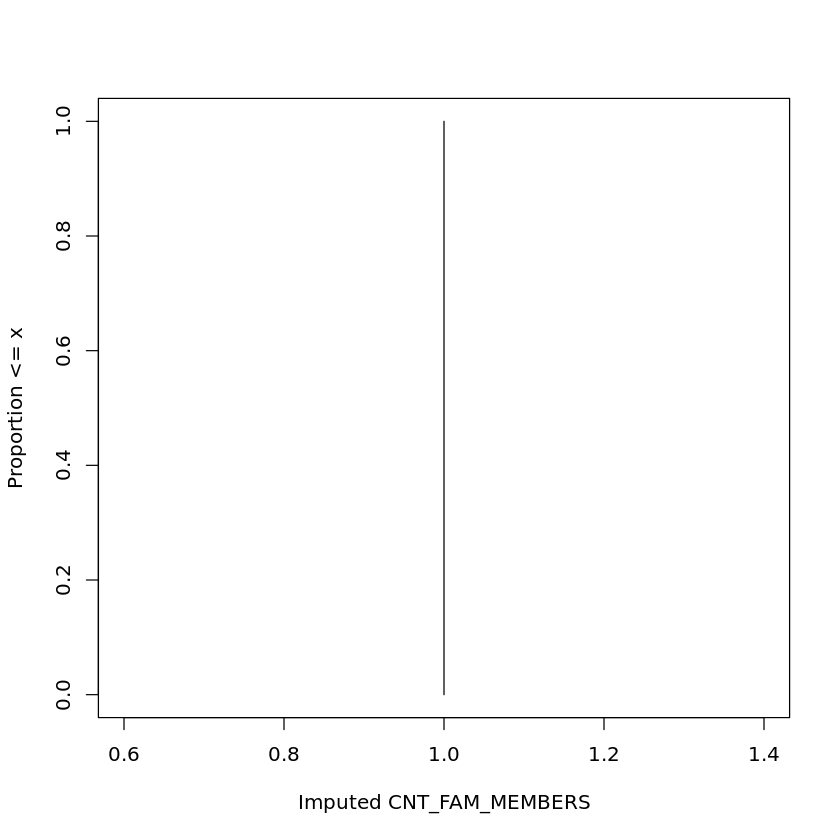

In [9]:
plot(mi)

In [10]:
print(mi)


Multiple Imputation using Bootstrap and PMM

aregImpute(formula = ~TARGET + NAME_CONTRACT_TYPE + CODE_GENDER + 
    AMT_CREDIT/AMT_GOODS_PRICE + AMT_CREDIT/AMT_ANNUITY + AMT_ANNUITY/AMT_INCOME_TOTAL + 
    EXT_SOURCE_1 + EXT_SOURCE_2 + EXT_SOURCE_3 + FLAG_OWN_REALTY + 
    CNT_CHILDREN + AMT_INCOME_TOTAL + AMT_CREDIT + AMT_ANNUITY + 
    AMT_GOODS_PRICE + NAME_TYPE_SUITE + NAME_EDUCATION_TYPE + 
    NAME_FAMILY_STATUS + NAME_HOUSING_TYPE + REGION_POPULATION_RELATIVE + 
    DAYS_BIRTH + DAYS_EMPLOYED + DAYS_REGISTRATION + DAYS_ID_PUBLISH + 
    OWN_CAR_AGE + FLAG_MOBIL + FLAG_EMP_PHONE + FLAG_WORK_PHONE + 
    FLAG_CONT_MOBILE + FLAG_PHONE + FLAG_EMAIL + OCCUPATION_TYPE + 
    CNT_FAM_MEMBERS, data = M, n.impute = 10, nk = 4, pr = FALSE)

n: 356255 	p: 30 	Imputations: 10  	nk: 4 

Number of NAs:
                    TARGET         NAME_CONTRACT_TYPE 
                     48744                          0 
               CODE_GENDER                 AMT_CREDIT 
                         4 

In [ ]:
 + 
    REGION_RATING_CLIENT + REGION_RATING_CLIENT_W_CITY + WEEKDAY_APPR_PROCESS_START + 
    HOUR_APPR_PROCESS_START + REG_REGION_NOT_LIVE_REGION + REG_REGION_NOT_WORK_REGION + 
    LIVE_REGION_NOT_WORK_REGION + REG_CITY_NOT_LIVE_CITY + REG_CITY_NOT_WORK_CITY + 
    LIVE_CITY_NOT_WORK_CITY + ORGANIZATION_TYPE + EXT_SOURCE_1 + 
    EXT_SOURCE_2 + EXT_SOURCE_3 + APARTMENTS_AVG + BASEMENTAREA_AVG + 
    YEARS_BEGINEXPLUATATION_AVG + YEARS_BUILD_AVG + COMMONAREA_AVG + 
    ELEVATORS_AVG + ENTRANCES_AVG + FLOORSMAX_AVG + FLOORSMIN_AVG + 
    LANDAREA_AVG + LIVINGAPARTMENTS_AVG + LIVINGAREA_AVG + NONLIVINGAPARTMENTS_AVG + 
    NONLIVINGAREA_AVG + APARTMENTS_MODE + BASEMENTAREA_MODE + 
    YEARS_BEGINEXPLUATATION_MODE + YEARS_BUILD_MODE + COMMONAREA_MODE + 
    ELEVATORS_MODE + ENTRANCES_MODE + FLOORSMAX_MODE + FLOORSMIN_MODE + 
    LANDAREA_MODE + LIVINGAPARTMENTS_MODE + LIVINGAREA_MODE + 
    NONLIVINGAPARTMENTS_MODE + NONLIVINGAREA_MODE + APARTMENTS_MEDI + 
    BASEMENTAREA_MEDI + YEARS_BEGINEXPLUATATION_MEDI + YEARS_BUILD_MEDI + 
    COMMONAREA_MEDI + ELEVATORS_MEDI + ENTRANCES_MEDI + FLOORSMAX_MEDI + 
    FLOORSMIN_MEDI + LANDAREA_MEDI + LIVINGAPARTMENTS_MEDI + 
    LIVINGAREA_MEDI + NONLIVINGAPARTMENTS_MEDI + NONLIVINGAREA_MEDI + 
    FONDKAPREMONT_MODE + HOUSETYPE_MODE + TOTALAREA_MODE + WALLSMATERIAL_MODE + 
    EMERGENCYSTATE_MODE + OBS_30_CNT_SOCIAL_CIRCLE + DEF_30_CNT_SOCIAL_CIRCLE + 
    OBS_60_CNT_SOCIAL_CIRCLE + DEF_60_CNT_SOCIAL_CIRCLE + DAYS_LAST_PHONE_CHANGE + 
    FLAG_DOCUMENT_2 + FLAG_DOCUMENT_3 + FLAG_DOCUMENT_4 + FLAG_DOCUMENT_5 + 
    FLAG_DOCUMENT_6 + FLAG_DOCUMENT_7 + FLAG_DOCUMENT_8 + FLAG_DOCUMENT_9 + 
    FLAG_DOCUMENT_10 + FLAG_DOCUMENT_11 + FLAG_DOCUMENT_12 + 
    FLAG_DOCUMENT_13 + FLAG_DOCUMENT_14 + FLAG_DOCUMENT_15 + 
    FLAG_DOCUMENT_16 + FLAG_DOCUMENT_17 + FLAG_DOCUMENT_18 + 
    FLAG_DOCUMENT_19 + FLAG_DOCUMENT_20 + FLAG_DOCUMENT_21 + 
    AMT_REQ_CREDIT_BUREAU_HOUR + AMT_REQ_CREDIT_BUREAU_DAY + 
    AMT_REQ_CREDIT_BUREAU_WEEK + AMT_REQ_CREDIT_BUREAU_MON + 
    AMT_REQ_CREDIT_BUREAU_QRT + AMT_REQ_CREDIT_BUREAU_YEAR

In [ ]:
test <- read.csv('application_test.csv') # applications test data
train <- read.csv('application_train.csv') # applications train data

# storing column names for later
saveNames <- names(train)

# columns with missing values
missingCols <-  names(train)[apply(train, 2, function(x) sum(is.na(x))) > 0]
                                   
#train imputation
medianDatatr <- imputationFunction(imputeToData = train, imputeFromData = train, FUN = median
                                   , missingCols = missingCols, suffix = '.trmedian')

#test imputation
medianDatatst.tst <- imputationFunction(imputeToData = test, imputeFromData = test, FUN = median
                                    , missingCols = missingCols, suffix = '.tstmedian')

## Initial Transformation to get to the Imputed Dataset

In [ ]:
weights <- read.csv('Weights_and_fold.csv')
print("Weights loaded")
train <- cbind(train, medianDatatr) %>% left_join(weights, by = "SK_ID_CURR")
write.csv(train,'application_train_imp.csv')
test <- cbind(test, medianDatatst.tst)
write.csv(test,'application_test_imp.csv')
rm(medianDatatr, medianDatatst.tst, weights)

In [ ]:
weights <- read.csv('V2_weight_R_code(Alex)/Train_Weights_V2.csv')
train <- read.csv('application_train_imp.csv') # applications train data
train <- train %>% select(-Weights, -X) %>% left_join(weights, by = "SK_ID_CURR") %>% select(-X)
write.csv(train,'application_train_imp.csv')

## Start Here for Subsequent Runs, read in the processed dataset

In [ ]:
test <- read.csv('application_test_imp.csv') # applications test data
train <- read.csv('application_train_imp.csv') # applications train data

In [ ]:
# Mechanically create a formula for rms modeling
M = train

col_set = M %>% names()
col_set = col_set[!col_set %in% "TARGET"]

string_formula = "TARGET~"
for(i in col_set){
  if(class(M[[i]]) == "numeric"){
    tmp_component = paste0("+rcs(",i,",3)")
  }
  if(class(M[[i]]) != "numeric"){
    tmp_component = paste0("+",i)
  }
  string_formula = paste0(string_formula, tmp_component)  
}
requested_formula = as.formula(string_formula)
requested_formula

### Base Model + AMT_CREDIT (Model FF_rms_2)

In [ ]:
#Perform 5 fold cross validation
model = list()
mod_anova = list()
test_roc = list()

for(i in 1:5){
    testData <- train[train$fold==i,]
    trainData <- train[train$fold!=i,]
    string_formula <- TARGET ~ NAME_CONTRACT_TYPE + CODE_GENDER + FLAG_OWN_CAR + FLAG_OWN_REALTY + rcs(EXT_SOURCE_1.trmedian, 4) + 
            rcs(EXT_SOURCE_2.trmedian, 4) + rcs(EXT_SOURCE_3.trmedian,4) + rcs(AMT_CREDIT, 3)
    requested_formula = as.formula(string_formula)
    a_model = lrm(data=trainData, formula = requested_formula, weight=Weights, tol=1E-10, x=TRUE,y=TRUE)
        
    # diagnostic plots
    ## Variable Importance
    mod_anova[[i]] <- anova(a_model)
    
    ## Validation Statistics
    print(validate(a_model, B=10))
    model[[i]] <- a_model

    ## Calibration Curve
    # plot(calibrate(a_model, B=10))

    # use a fitted model to score a dataset, convert score to probability
    test_scored <- cbind(testData, predict(a_model, testData, se.fit=TRUE))
    test_scored$pred = exp(test_scored$linear.predictors)/(1+exp(test_scored$linear.predictors))

    # Weighted AUROC
    tp.fp <- WeightedROC(test_scored$pred,test_scored$TARGET,test_scored$Weights)
    test_roc[[i]] <- WeightedAUC(tp.fp)
    print(test_roc[[i]])

    # Unweighted AUROC
    tp.fp <- WeightedROC(test_scored$pred,test_scored$TARGET)
    print(WeightedAUC(tp.fp))
    
}

In [ ]:
#Perform 5 fold cross validation
model = list()
mod_anova = list()
test_roc = list()

for(i in 1:5){
    testData <- train[train$fold==i,]
    trainData <- train[train$fold!=i,]
    string_formula <- TARGET ~ NAME_CONTRACT_TYPE + CODE_GENDER + FLAG_OWN_CAR + FLAG_OWN_REALTY + rcs(EXT_SOURCE_1.trmedian, 4) + 
            rcs(EXT_SOURCE_2.trmedian, 4) + rcs(EXT_SOURCE_3.trmedian,4)
    requested_formula = as.formula(string_formula)
    a_model = lrm(data=trainData, formula = requested_formula, weight=Weights, tol=1E-10, x=TRUE,y=TRUE)
        
    # diagnostic plots
    ## Variable Importance
    mod_anova[[i]] <- anova(a_model)
    
    ## Validation Statistics
    print(validate(a_model, B=10))
    model[[i]] <- a_model

    ## Calibration Curve
    # plot(calibrate(a_model, B=10))

    # use a fitted model to score a dataset, convert score to probability
    test_scored <- cbind(testData, predict(a_model, testData, se.fit=TRUE))
    test_scored$pred = exp(test_scored$linear.predictors)/(1+exp(test_scored$linear.predictors))

    # Weighted AUROC
    tp.fp <- WeightedROC(test_scored$pred,test_scored$TARGET,test_scored$Weights)
    test_roc[[i]] <- WeightedAUC(tp.fp)
    print(test_roc[[i]])

    # Unweighted AUROC
    tp.fp <- WeightedROC(test_scored$pred,test_scored$TARGET)
    print(WeightedAUC(tp.fp))
    
}

In [ ]:
# Trying to understand why adding AMT_CREDIT, AMT_INCOME_TOTAL to the model would cause information matrix singularity
train_samp_col <- train %>% select(AMT_CREDIT, AMT_INCOME_TOTAL)
hist(train_samp_col)
# the value seems pretty ordinary

cor(trainData[,c("EXT_SOURCE_1.trmedian", "EXT_SOURCE_2.trmedian", "EXT_SOURCE_3.trmedian", "AMT_CREDIT", "AMT_INCOME_TOTAL")])

### Train FF_rms_2 on the full dataset and create submission

In [ ]:
string_formula <- TARGET ~ NAME_CONTRACT_TYPE + CODE_GENDER + FLAG_OWN_CAR + FLAG_OWN_REALTY + rcs(EXT_SOURCE_1.trmedian, 4) + 
            rcs(EXT_SOURCE_2.trmedian, 4) + rcs(EXT_SOURCE_3.trmedian,4) + rcs(AMT_CREDIT, 3)
requested_formula = as.formula(string_formula)
a_model = lrm(data=train, formula = requested_formula, weight=Weights, tol=1E-10, x=TRUE,y=TRUE)

# Diagnostic Plots
## Variable Importance
plot(anova(a_model))
## Partial Effect Plot
dd <- datadist(train); options(datadist='dd')
ggplot(Predict(a_model),sepdiscrete='vertical',vnames='names')

In [ ]:
a_model

In [ ]:
test$EXT_SOURCE_1.trmedian = test$EXT_SOURCE_1.tstmedian
test$EXT_SOURCE_2.trmedian = test$EXT_SOURCE_2.tstmedian
test$EXT_SOURCE_3.trmedian = test$EXT_SOURCE_3.tstmedian

In [ ]:
test_scored <- cbind(test, predict(a_model, test, se.fit=TRUE))
test_scored$TARGET <- exp(test_scored$linear.predictors)/(1+exp(test_scored$linear.predictors))
submission <- test_scored %>% select(SK_ID_CURR, TARGET)
write.csv(submission, "test_scored.csv")